In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import csv
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
import importlib
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
import CleanData, SaveState
importlib.reload(CleanData)
importlib.reload(SaveState)
from CleanData import clean_comment, get_bag_of_words

C:\Users\zchao\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


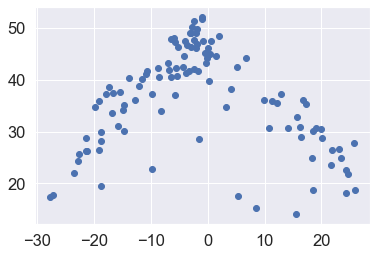

In [2]:
# Load all article reviews from MediaBiasChart V5.0:
media_bias = pd.read_csv('../data/MediaBiasChart.csv')
media_bias = media_bias.groupby('Source').mean()
media_bias.reset_index(level=0, inplace=True)
plt.scatter(media_bias['Bias'].to_numpy(),media_bias['Quality'].to_numpy())

In [3]:
MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

media_bias['Source'] = media_bias.Source.map(MediaBiasChart_to_Tweet)
media_bias = media_bias.dropna()
media_bias = media_bias.reset_index(drop=True)

In [4]:
frac = 0.2  # This frac stands for the percentage of media to be selected as left/right media
left_bound = media_bias.Bias.quantile(frac)
right_bound = media_bias.Bias.quantile(1-frac)
low_bound = media_bias.Quality.quantile(frac)
high_bound = media_bias.Quality.quantile(1-frac)
all_media = media_bias['Source'].tolist()
left_media = media_bias.loc[media_bias['Bias']<=left_bound]
left_media = left_media['Source'].tolist()
right_media = media_bias.loc[media_bias['Bias']>=right_bound]
right_media = right_media['Source'].tolist()
low_media = media_bias.loc[media_bias['Quality']<=low_bound]
low_media = low_media['Source'].tolist()
high_media = media_bias.loc[media_bias['Quality']>=high_bound]
high_media = high_media['Source'].tolist()

# neutral_media = media_bias.loc[(media_bias['Bias']>=-6) & (media_bias['Bias']<=6)]
# neutral_media = neutral_media['Source'].tolist()
len(left_media), len(right_media), len(low_media), len(high_media) #, len(neutral_media)

(13, 13, 13, 13)

In [5]:
# int(len(left_media)/2)

In [6]:
df1 = pd.read_csv('../data/filtered_part1.csv', skiprows=1)
df2 = pd.read_csv('../data/filtered_part2.csv')
df3 = pd.read_csv('../data/filtered_part3.csv')
df4 = pd.read_csv('../data/filtered_part4.csv',lineterminator='\n')
df6 = pd.read_csv('../data/filtered_part6.csv')
df7 = pd.read_csv('../data/filtered_part7.csv')
df8 = pd.read_csv('../data/filtered_part8.csv')
df = pd.concat([df1, df2, df3, df4, df6, df7, df8], sort = False)
df.shape

(1435714, 4)

In [7]:
all_media = media_bias['Source'].tolist()
df = df.loc[df['user_screen_name'].isin(all_media)]
df.shape

(1418451, 4)

In [8]:
df.head(5)

user_screen_name  \
0  ABC               
1  ABC               
2  ABC               
3  ABC               
4  ABC               

                                                                                                                                                text  \
0  Fidel Castro Dead at 90: Barbara Walters talks about her meetings with Castro https://t.co/vTDFsXtjv9 https://t.co/cdcWOu2and                       
1  Fidel Castro Dead at 90: Miami's Little Havana filled with revellers https://t.co/Y3wBU37gF2 https://t.co/lYlLfXWBeN                                
2  World leaders from Justin Trudeau to Vladimir Putin to Pope Francis react to Fidel Castro's death https://t.co/Tp5BtEmnYw https://t.co/c8jHy51R9a   
3  World leaders and public figures react to former Cuban leader Fidel Castro's death at age 90: https://t.co/1LUhtbo2rF https://t.co/eLkLfZPpBP       
4  Fidel Castro's funeral set for December 4 following a period of public mourning https://t.co/7OzTdARiuo https://t.co/hHq1u4YKzD                     

                  created_at hashtags  
0  2016-11-26 11:00:10+00:00  NaN      
1  2016-11-26 10:11:27+00:00  NaN      
2  2016-11-26 15:08:55+00:00  NaN      
3  2016-11-26 07:52:34+00:00  NaN      
4  2016-11-26 15:43:39+00:00  NaN

In [9]:
import random
from random import sample
df = df.sample(frac=1).reset_index(drop=True)
df = df.groupby('user_screen_name').head(30000).reset_index(drop=True)
df[df.user_screen_name.isin(left_media)].shape, df[df.user_screen_name.isin(right_media)].shape

((193429, 4), (185725, 4))

In [10]:
# not able to process all tweets, so we only take tweets in 2018 for now
df_2018 = df.loc[((df['created_at']) >= '2018-01-01') & ((df['created_at']) <= '2018-12-31')]
df_2018 = df_2018.reset_index(drop = True)
import preprocessor as p
df_2018['text']  = df_2018['text'].apply(p.clean)

In [11]:
bag_of_words, vectorizer = get_bag_of_words(df_2018['text'],ngram_range=(1,2), min_df=0.001)

In [12]:
df_2018['text'].shape

(340883,)

In [24]:
df_2018.loc[(df_2018['text'].str.contains('wildfire'))&(df_2018['text'].str.contains('amazon'))]

Empty DataFrame
Columns: [user_screen_name, text, created_at, hashtags]
Index: []

In [24]:


# Train binary multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
def get_binary_NB_model_LR(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[df['user_screen_name'].isin(train_left),:]
    class2_words = bag_of_words[df['user_screen_name'].isin(train_right),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb
nb_model = get_binary_NB_model_LR(bag_of_words, df_2018)

['MotherJones', 'voxdotcom', 'CNN', 'HuffPost', 'Slate', 'newrepublic'] ['newsmax', 'FoxNews', 'OANN', 'NRO', 'DailySignal', 'DailyCaller']
Training Accuracy: 0.7183927131268086
33246 11741 12003 27326


In [25]:
# predictions = nb_model.predict(bag_of_words[tweets_df['user_name'].isin(test_users),:])
# tweets_df['nb_tweet_pred'] = np.NaN
# tweets_df.loc[tweets_df['user_name'].isin(test_users),['nb_tweet_pred']] = predictions
predict_probs = nb_model.predict_proba(bag_of_words)
df_2018['right_prob'] = predict_probs[:,1]

In [26]:
# # Make scatter plots for train_left/right, test_left/right, neutral[0:6],[6:12]:
# plt.figure(figsize=(16, 14))
# plt.title('train_left', fontsize=30)
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(train_left)])

# plt.figure(figsize=(16, 14))
# plt.title('train_right', fontsize=30)
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(train_right)])

# test_left = list(set(left_media)-set(train_left))
# plt.figure(figsize=(16, 14))
# plt.title('test_left', fontsize=30)
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(test_left)])

# test_right = list(set(right_media)-set(train_right))
# plt.figure(figsize=(16, 14))
# plt.title('test_right', fontsize=30)
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(test_right)])

# plt.figure(figsize=(16, 14))
# plt.title('neutral', fontsize=30)
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(neutral_media[0:6])])

# plt.figure(figsize=(16, 14))
# sns.violinplot(x='user_screen_name', y='left_prob', data=df_2018.loc[df_2018['user_screen_name'].isin(neutral_media[6:12])])

In [27]:
average_right_prob = df_2018.groupby(['user_screen_name']).right_prob.mean()
# average_right_prob

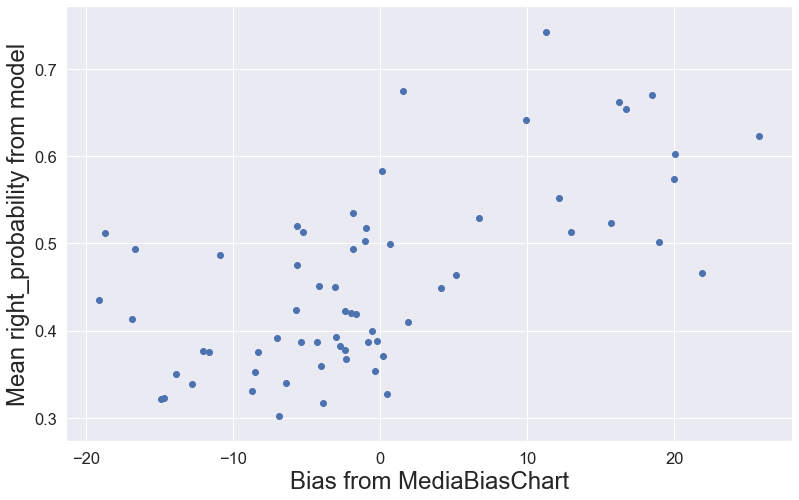

In [28]:
media_bias = media_bias.sort_values(by = 'Source')
bias = media_bias[media_bias.Source != 'propublica'].Bias
plt.figure(figsize=(13, 8))
plt.xlabel('Bias from MediaBiasChart', fontsize=24)
plt.ylabel('Mean right_probability from model', fontsize=24)
plt.scatter(bias.tolist(), average_right_prob.tolist())

In [29]:
# Pearson Correlation between the bias from MediaBiasChart and Reconstructed by tweet contents
import scipy.stats
scipy.stats.pearsonr(average_right_prob.tolist(), bias.tolist())[0]

0.6375409780844035

In [30]:
# N = 64
# np.random.seed(1)
# colors = np.random.rand(N)
# quality = media_bias[media_bias.Source != 'propublica'].Quality
# n_tweets = df_2018.groupby(['user_screen_name']).size().tolist()
# size = [x**2 / 100000 for x in n_tweets]
# plt.figure(figsize=(16, 10))
# plt.scatter(bias.tolist(), quality.tolist(), s=size, c=colors, alpha=0.5)
# names = df_2018.groupby(['user_screen_name']).size().index.tolist()
# for i, name in enumerate(names):
#     plt.annotate(name, (bias.tolist()[i], quality.tolist()[i]))
# plt.xlim(-25, 25)
# plt.show()

In [31]:
# # Now generate the quality score similarly
# low_media = media_bias.loc[media_bias['Quality']<=35]
# low_media = low_media['Source'].tolist()
# high_media = media_bias.loc[media_bias['Quality']>=45]
# high_media = high_media['Source'].tolist()
# len(low_media), len(high_media)

In [32]:
random.seed(0)
train_high = sample(high_media,int(len(high_media)/2))
train_low = sample(low_media,int(len(low_media)/2))
test_high = list(set(high_media)-set(train_high))
test_low = list(set(low_media)-set(train_low))
print(train_high, train_low)

['NPR', 'weatherchannel', 'ABC', 'FT', 'PBS', 'nytimes'] ['NRO', 'FoxNews', 'Slate', 'freespeechtv', 'DailySignal', 'DailyCaller']


In [33]:
# Train binary multinomial Naive Bayes model. This one is for Low/High Quality
def get_binary_NB_model_LH(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[df['user_screen_name'].isin(train_low),:]
    class2_words = bag_of_words[df['user_screen_name'].isin(train_high),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb
nb_model = get_binary_NB_model_LH(bag_of_words, df_2018)

Training Accuracy: 0.7391822372669977
40563 14017 9406 25820


In [34]:
predict_probs = nb_model.predict_proba(bag_of_words)
df_2018['low_prob'] = predict_probs[:,0]
df_2018['high_prob'] = predict_probs[:,1]
df_2018['nb_tweet_pred_LH'] = nb_model.predict(bag_of_words)

In [36]:
df_2018.head(5)

user_screen_name  \
0  newrepublic       
1  newrepublic       
2  newrepublic       
3  newrepublic       
4  newrepublic       

                                                                                                                                                               text  \
0  "If you start to separate the idea of movie theaters from movies, then in fact it’s a great time." Ben Fritz on the future of streaming services and the movies:   
1  The case for banning targeted advertising altogether:                                                                                                              
2  The age of Trump is also the age of conspiracy.                                                                                                                    
3  From false flags to fake news, the nation’s tin foil hats are ascendant in the age of Trump.                                                                       
4  : I had some thoughts about free speech and censorship at Christian colleges, including the one I attended                                                         

                  created_at hashtags  left_prob  right_prob  pred_LR  \
0  2018-04-09 23:30:13+00:00  NaN      0.968870   0.031130    0.0       
1  2018-04-10 11:00:17+00:00  NaN      0.511031   0.488969    0.0       
2  2018-04-09 21:40:02+00:00  NaN      0.967191   0.032809    0.0       
3  2018-04-10 03:30:10+00:00  NaN      0.210999   0.789001    1.0       
4  2018-04-10 14:28:02+00:00  NaN      0.217605   0.782395    1.0       

   low_prob  high_prob  nb_tweet_pred_LH  
0  0.975761  0.024239   0.0               
1  0.525161  0.474839   0.0               
2  0.566276  0.433724   0.0               
3  0.928921  0.071079   0.0               
4  0.862383  0.137617   0.0

In [37]:
testLR_correct = sum(df_2018[df_2018['user_screen_name'].isin(test_left)].right_prob <= 0.5) + \
                 sum(df_2018[df_2018['user_screen_name'].isin(test_right)].right_prob > 0.5)
testLH_correct = sum(df_2018[df_2018['user_screen_name'].isin(test_low)].high_prob <= 0.5) + \
                 sum(df_2018[df_2018['user_screen_name'].isin(test_high)].high_prob > 0.5)
print('LR Testing Accuracy: ' + str(testLR_correct/sum(df_2018['user_screen_name'].isin(test_left+test_right))))
print('LH Testing Accuracy: ' + str(testLH_correct/sum(df_2018['user_screen_name'].isin(test_low+test_high))))

LR Testing Accuracy: 0.5609164983633957
LH Testing Accuracy: 0.6699050153151203


##Try find keywords of some specific topic and create filter

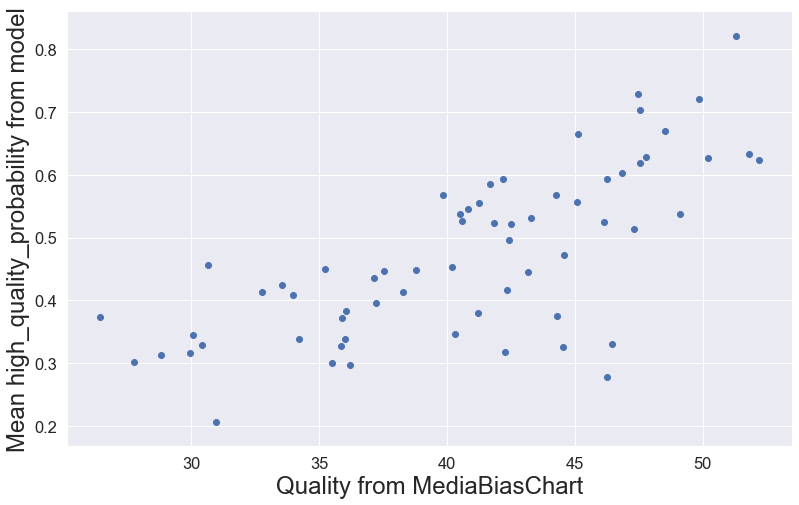

In [38]:
average_high_prob = df_2018.groupby(['user_screen_name']).high_prob.mean()
media_bias = media_bias.sort_values(by = 'Source')
quality = media_bias[media_bias.Source != 'propublica'].Quality

plt.figure(figsize=(13, 8))
plt.xlabel('Quality from MediaBiasChart', fontsize=24)
plt.ylabel('Mean high_quality_probability from model', fontsize=24)
plt.scatter(quality.tolist(), average_high_prob.tolist())


In [39]:
# Pearson Correlation between the bias from MediaBiasChart and Reconstructed by tweet contents
import scipy.stats
scipy.stats.pearsonr(average_high_prob.tolist(), quality.tolist())[0]

0.7185543924765516

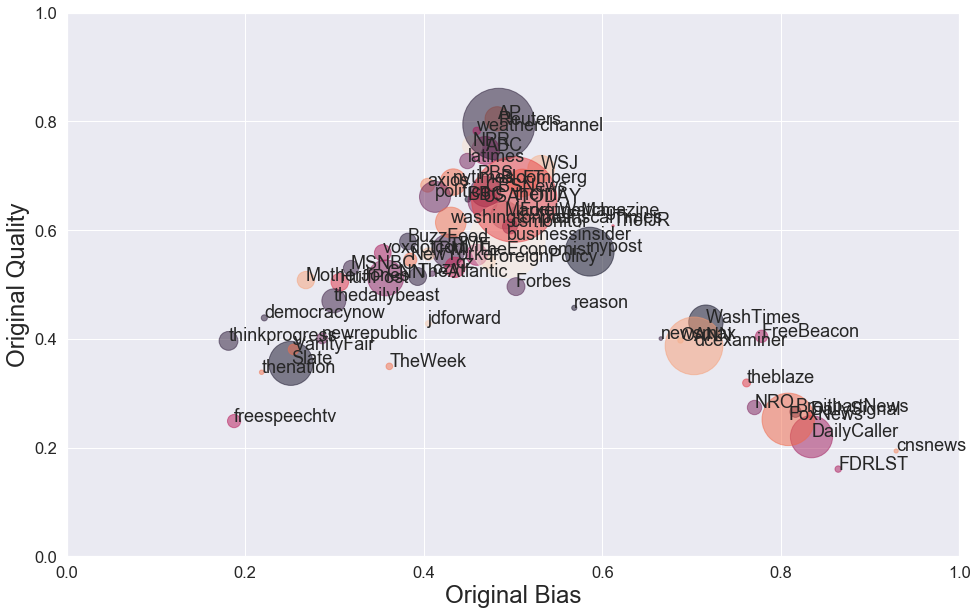

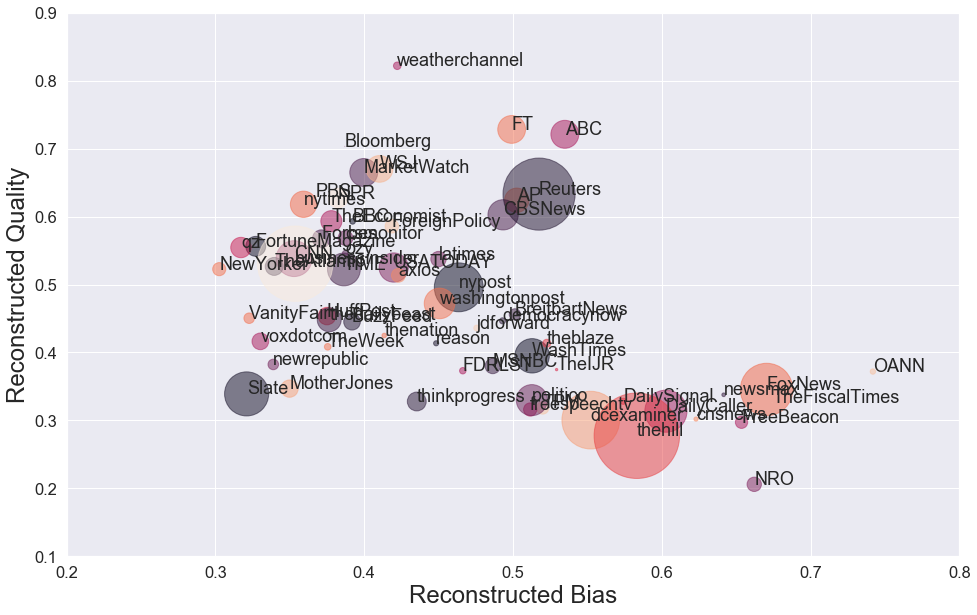

In [40]:
n_tweets = df_2018.groupby(['user_screen_name']).size()
n_tweets = n_tweets.rename("n_tweets")
media_bias = media_bias.set_index('Source').join(average_right_prob).join(average_high_prob).join(n_tweets)
media_bias = media_bias.dropna()
media_bias = media_bias.reset_index()


N = media_bias.shape[0]

names = media_bias.Source.tolist()

np.random.seed(1)
colors = np.random.rand(N)

size = [x**2 / 100000 for x in media_bias.n_tweets.tolist()]

x0 = [(x+30)/60 for x in media_bias.Bias.tolist()]
y0 = [(x-20)/40 for x in media_bias.Quality.tolist()]
x1 = average_right_prob.tolist()
y1 = average_high_prob.tolist()

plt.figure(figsize=(16, 10))
plt.scatter(x0, y0, s=size, c=colors, alpha=0.5)
for i, name in enumerate(names):
    plt.annotate(name, (x0[i], y0[i]))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Original Bias', fontsize=24)
plt.ylabel('Original Quality', fontsize=24)
plt.show()


plt.figure(figsize=(16, 10))
for i, name in enumerate(names):
    plt.annotate(name, (x1[i], y1[i]))
plt.scatter(x1, y1, s=size, c=colors, alpha=0.5)
plt.xlim(0.2, 0.8)
plt.ylim(0.1, 0.9)
plt.xlabel('Reconstructed Bias', fontsize=24)
plt.ylabel('Reconstructed Quality', fontsize=24)
plt.show()

In [ ]:
# media_bias

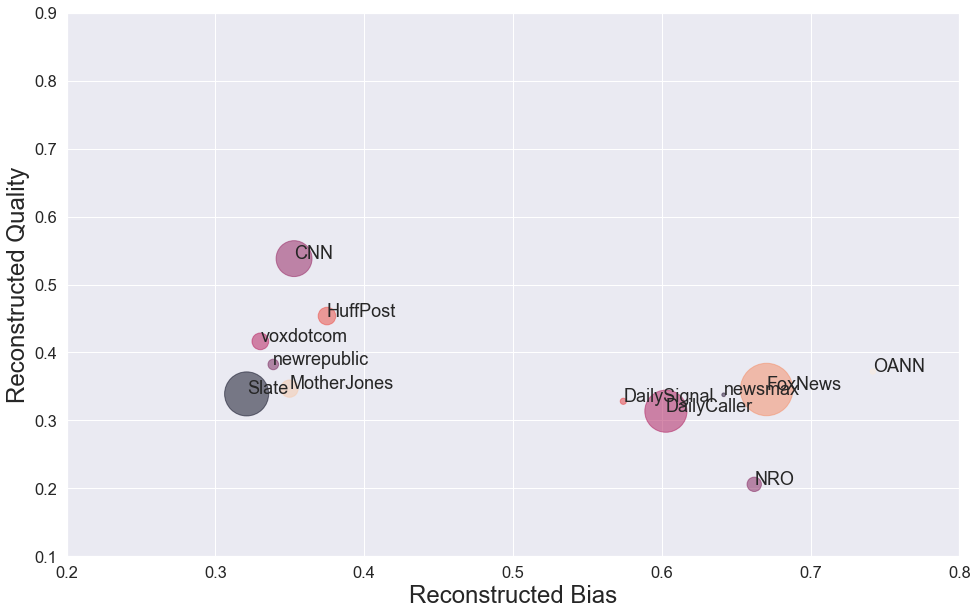

In [41]:
def plotsubset(names, dir1, dir2):
    index = media_bias.Source.isin(names)

    names = media_bias[index].Source.tolist()
    x0 = [(x+30)/60 for x in media_bias[index].Bias.tolist()]
    y0 = [(x-20)/40 for x in media_bias[index].Quality.tolist()]
    x1 = media_bias[index].right_prob.tolist()
    y1 = media_bias[index].high_prob.tolist()
    size = [x**2 / 100000 for x in media_bias[index].n_tweets.tolist()]
    color = pd.Series(colors)[index].tolist()
    
    plt.figure(figsize=(16, 10))
    # pd.Series(size)
    plt.scatter(x0, y0, s=size, c=color, alpha=0.5)
    for i, name in enumerate(names):
        plt.annotate(name, (x0[i], y0[i]))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Original Bias', fontsize=24)
    plt.ylabel('Original Quality', fontsize=24)
    plt.savefig(dir1)
    plt.show()
    

    plt.figure(figsize=(16, 10))
    for i, name in enumerate(names):
        plt.annotate(name, (x1[i], y1[i]))
    plt.scatter(x1, y1, s=size, c=color, alpha=0.5)
    plt.xlim(0.2, 0.8)
    plt.ylim(0.1, 0.9)
    plt.xlabel('Reconstructed Bias', fontsize=24)
    plt.ylabel('Reconstructed Quality', fontsize=24)
    plt.savefig(dir2)
    plt.show()
    
    
names = train_left + train_right
dir1 = '../../../../Downloads/20200427/media_trainB_origin.png'
dir2 = '../../../../Downloads/20200427/media_trainB_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
names = list(set(left_media + right_media) - set(train_left + train_right))
dir1 = '../../../../Downloads/20200427/media_testB_origin.png'
dir2 = '../../../../Downloads/20200427/media_testB_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
names = train_high + train_low
dir1 = '../../../../Downloads/20200427/media_trainQ_origin.png'
dir2 = '../../../../Downloads/20200427/media_trainQ_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
names = list(set(high_media + low_media) - set(train_high + train_low))
dir1 = '../../../../Downloads/20200427/media_testQ_origin.png'
dir2 = '../../../../Downloads/20200427/media_testQ_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
names = list(set(media_bias['Source'].tolist()) - set(left_media + right_media))
dir1 = '../../../../Downloads/20200427/media_rest_origin.png'
dir2 = '../../../../Downloads/20200427/media_rest_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
df_2018 = df_2018[['user_screen_name', 'text']]

In [ ]:
df_2018['sampled'] = np.random.randint(2, size=df_2018.shape[0])
def get_binary_NB_model_LR(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[(df['user_screen_name'].isin(left_media)) & (df['sampled'] == 1),:]
    class2_words = bag_of_words[(df['user_screen_name'].isin(right_media)) & (df['sampled'] == 1),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb

nb_model = get_binary_NB_model_LR(bag_of_words, df_2018)

In [ ]:
predict_probs = nb_model.predict_proba(bag_of_words)
df_2018['left_prob'] = predict_probs[:,0]
df_2018['right_prob'] = predict_probs[:,1]
df_2018['pred_LR'] = nb_model.predict(bag_of_words)

In [ ]:
average_right_prob = df_2018[~(df_2018['user_screen_name'].isin(left_media + right_media) & df_2018['sampled'] == 1)].groupby(['user_screen_name']).right_prob.mean()
media_bias = media_bias.sort_values(by = 'Source')
bias = media_bias[media_bias.Source != 'propublica'].Bias
plt.scatter(bias.tolist(), average_right_prob.tolist())

In [ ]:
def get_binary_NB_model_LR(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[(df['user_screen_name'].isin(low_media)) & (df['sampled'] == 1),:]
    class2_words = bag_of_words[(df['user_screen_name'].isin(high_media)) & (df['sampled'] == 1),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb

nb_model = get_binary_NB_model_LR(bag_of_words, df_2018)

In [ ]:
predict_probs = nb_model.predict_proba(bag_of_words)
df_2018['low_prob'] = predict_probs[:,0]
df_2018['high_prob'] = predict_probs[:,1]
df_2018['pred_LH'] = nb_model.predict(bag_of_words)

In [ ]:
average_high_prob = df_2018[~(df_2018['user_screen_name'].isin(low_media + high_media) & df_2018['sampled'] == 1)].groupby(['user_screen_name']).high_prob.mean()
quality = media_bias[media_bias.Source != 'propublica'].Quality
plt.scatter(quality.tolist(), average_high_prob.tolist())

In [ ]:
print('LR Pearson Correlation:'+str(scipy.stats.pearsonr(average_right_prob.tolist(), bias.tolist())[0]))
print('LH Pearson Correlation:'+str(scipy.stats.pearsonr(average_high_prob.tolist(), quality.tolist())[0]))

In [ ]:
testLR_correct = sum(df_2018[(df_2018['user_screen_name'].isin(test_left)) & (df_2018['sampled'] == 0)].pred_LR == 0) + \
                 sum(df_2018[(df_2018['user_screen_name'].isin(test_right)) & (df_2018['sampled'] == 0)].pred_LR == 1)
testLH_correct = sum(df_2018[(df_2018['user_screen_name'].isin(test_low)) & (df_2018['sampled'] == 0)].pred_LH == 0) + \
                 sum(df_2018[(df_2018['user_screen_name'].isin(test_high)) & (df_2018['sampled'] == 0)].pred_LH == 1)
print('LR Testing Accuracy: ' + str(testLR_correct/sum((df_2018['user_screen_name'].isin(test_left+test_right)) & (df_2018['sampled'] == 0))))
print('LH Testing Accuracy: ' + str(testLH_correct/sum((df_2018['user_screen_name'].isin(test_low+test_high)) & (df_2018['sampled'] == 0))))

In [ ]:
df_2018_test = df_2018[df_2018['sampled'] == 0]
n_tweets = df_2018_test.groupby(['user_screen_name']).size()
n_tweets = n_tweets.rename("n_tweets")
media_bias = media_bias.set_index('Source').join(average_right_prob).join(average_high_prob).join(n_tweets)
media_bias = media_bias.dropna()
media_bias = media_bias.reset_index()


N = media_bias.shape[0]

names = media_bias.Source.tolist()

np.random.seed(1)
colors = np.random.rand(N)

size = [x**2 / 100000 for x in media_bias.n_tweets.tolist()]

x0 = [(x+30)/60 for x in media_bias.Bias.tolist()]
y0 = [(x-20)/40 for x in media_bias.Quality.tolist()]
x1 = average_right_prob.tolist()
y1 = average_high_prob.tolist()

plt.figure(figsize=(16, 10))
plt.scatter(x0, y0, s=size, c=colors, alpha=0.5)
for i, name in enumerate(names):
    plt.annotate(name, (x0[i], y0[i]))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Original Bias', fontsize=24)
plt.ylabel('Original Quality', fontsize=24)
plt.show()


plt.figure(figsize=(16, 10))
for i, name in enumerate(names):
    plt.annotate(name, (x1[i], y1[i]))
plt.scatter(x1, y1, s=size, c=colors, alpha=0.5)
plt.xlim(0.2, 0.8)
plt.ylim(0.1, 0.9)
plt.xlabel('Reconstructed Bias', fontsize=24)
plt.ylabel('Reconstructed Quality', fontsize=24)
plt.show()

In [ ]:
def plotsubset(names, dir1, dir2):
    index = media_bias.Source.isin(names)

    names = media_bias[index].Source.tolist()
    x0 = [(x+30)/60 for x in media_bias[index].Bias.tolist()]
    y0 = [(x-20)/40 for x in media_bias[index].Quality.tolist()]
    x1 = media_bias[index].right_prob.tolist()
    y1 = media_bias[index].high_prob.tolist()
    size = [x**2 / 100000 for x in media_bias[index].n_tweets.tolist()]
    color = pd.Series(colors)[index].tolist()
    
    plt.figure(figsize=(16, 10))
    # pd.Series(size)
    plt.scatter(x0, y0, s=size, c=color, alpha=0.5)
    for i, name in enumerate(names):
        plt.annotate(name, (x0[i], y0[i]))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Original Bias', fontsize=24)
    plt.ylabel('Original Quality', fontsize=24)
    plt.savefig(dir1)
    plt.show()
    

    plt.figure(figsize=(16, 10))
    for i, name in enumerate(names):
        plt.annotate(name, (x1[i], y1[i]))
    plt.scatter(x1, y1, s=size, c=color, alpha=0.5)
    plt.xlim(0.2, 0.8)
    plt.ylim(0.1, 0.9)
    plt.xlabel('Reconstructed Bias', fontsize=24)
    plt.ylabel('Reconstructed Quality', fontsize=24)
    plt.savefig(dir2)
    plt.show()
    
    
names = left_media
dir1 = '../../../../Downloads/20200427/media_trainB_origin.png'
dir2 = '../../../../Downloads/20200427/media_trainB_recon.png'
plotsubset(names, dir1, dir2)

In [ ]:
names = right_media
plotsubset(names, dir1, dir2)

In [ ]:
names = high_media
plotsubset(names, dir1, dir2)

In [ ]:
names = low_media
plotsubset(names, dir1, dir2)

In [42]:
df_2018.head()

user_screen_name  \
0  newrepublic       
1  newrepublic       
2  newrepublic       
3  newrepublic       
4  newrepublic       

                                                                                                                                                               text  \
0  "If you start to separate the idea of movie theaters from movies, then in fact it’s a great time." Ben Fritz on the future of streaming services and the movies:   
1  The case for banning targeted advertising altogether:                                                                                                              
2  The age of Trump is also the age of conspiracy.                                                                                                                    
3  From false flags to fake news, the nation’s tin foil hats are ascendant in the age of Trump.                                                                       
4  : I had some thoughts about free speech and censorship at Christian colleges, including the one I attended                                                         

                  created_at hashtags  left_prob  right_prob  pred_LR  \
0  2018-04-09 23:30:13+00:00  NaN      0.968870   0.031130    0.0       
1  2018-04-10 11:00:17+00:00  NaN      0.511031   0.488969    0.0       
2  2018-04-09 21:40:02+00:00  NaN      0.967191   0.032809    0.0       
3  2018-04-10 03:30:10+00:00  NaN      0.210999   0.789001    1.0       
4  2018-04-10 14:28:02+00:00  NaN      0.217605   0.782395    1.0       

   low_prob  high_prob  nb_tweet_pred_LH  
0  0.975761  0.024239   0.0               
1  0.525161  0.474839   0.0               
2  0.566276  0.433724   0.0               
3  0.928921  0.071079   0.0               
4  0.862383  0.137617   0.0

In [53]:
df_sample = df_2018.groupby('user_screen_name').head(2)

In [54]:
df_sample.shape

(128, 10)

In [55]:
df_2018.shape

(426493, 10)

In [57]:
df_sample.head(10).reset_index(drop=True)

user_screen_name  \
0  newrepublic       
1  newrepublic       
2  FT                
3  FT                
4  NRO               
5  NRO               
6  Slate             
7  Slate             
8  PBS               
9  PBS               

                                                                                                                                                               text  \
0  "If you start to separate the idea of movie theaters from movies, then in fact it’s a great time." Ben Fritz on the future of streaming services and the movies:   
1  The case for banning targeted advertising altogether:                                                                                                              
2  SFO names chief operating officer Mark Thompson as interim director                                                                                                
3  Axa revamps Swiss unit to allow riskier business                                                                                                                   
4  The Cohen Raid via                                                                                                                                                 
5  Americans Still Aren’t Moving to via                                                                                                                               
6  In moments of medical crisis, you need a doctor who can help you navigate uncertainty:                                                                             
7  Stormy Daniels’ motion to depose Trump is on stunningly solid legal footing:                                                                                       
8  Wondering what treasures await on ? Watch tonight at /7c!                                                                                                          
9  Officials in Washington worked Sunday to verify the claim that the Assad government was responsible for the suspected gas attack. (From )                          

                  created_at          hashtags  left_prob  right_prob  \
0  2018-04-09 23:30:13+00:00  NaN               0.968870   0.031130     
1  2018-04-10 11:00:17+00:00  NaN               0.511031   0.488969     
2  2018-04-10 09:09:53+00:00  NaN               0.604198   0.395802     
3  2018-04-10 07:18:31+00:00  NaN               0.515637   0.484363     
4  2018-04-10 15:30:22+00:00  MichaelCohenRaid  0.332981   0.667019     
5  2018-04-10 13:50:04+00:00  Canada            0.241111   0.758889     
6  2018-04-10 07:54:20+00:00  NaN               0.806660   0.193340     
7  2018-04-10 13:03:21+00:00  NaN               0.942678   0.057322     
8  2018-04-09 22:00:02+00:00  AntiquesRoadshow  0.237088   0.762912     
9  2018-04-09 17:17:04+00:00  NaN               0.087499   0.912501     

   pred_LR  low_prob  high_prob  nb_tweet_pred_LH  
0  0.0      0.975761  0.024239   0.0               
1  0.0      0.525161  0.474839   0.0               
2  0.0      0.145395  0.854605   1.0               
3  0.0      0.378178  0.621822   1.0               
4  1.0      0.990113  0.009887   0.0               
5  1.0      0.982307  0.017693   0.0               
6  0.0      0.538765  0.461235   0.0               
7  0.0      0.868327  0.131673   0.0               
8  1.0      0.532027  0.467973   0.0               
9  1.0      0.221630  0.778370   1.0